In [1]:
from teleconnections import Teleconnection

In [2]:
tc_ERA = Teleconnection(model='ERA5', exp='era5', source='monthly', telecname='NAO', loglevel='INFO', startdate='1990-01-01', enddate='2020-12-31', regrid='r100', savefig=False, savefile=False)

2024-03-25 16:06:58 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-03-25 16:06:58 :: Teleconnection :: INFO     -> Namelist loaded
2024-03-25 16:06:58 :: Reader :: INFO     -> Fix names in metadata is ERA5-destine-v1
2024-03-25 16:06:58 :: Reader :: INFO     -> Fix names ERA5-destine-v1 found in fixes files
2024-03-25 16:06:59 :: Reader :: INFO     -> Grid metadata is era5-r025


2024-03-25 16:07:05 :: Teleconnection :: INFO     -> Reader initialized


In [3]:
tc_ERA.evaluate_index()

2024-03-25 16:07:05 :: Teleconnection :: INFO     -> No retrieve has been performed, trying to retrieve
2024-03-25 16:07:05 :: Reader :: INFO     -> Retrieving variables: ['msl']
2024-03-25 16:07:05 :: Reader :: INFO     -> Retrieving variables: ['msl']
2024-03-25 16:07:06 :: Reader :: INFO     -> Variables to be fixed: {'msl': {'grib': True, 'source': 'MSL'}}
2024-03-25 16:07:06 :: Reader :: INFO     -> msl: converting units Pa --> Pa
2024-03-25 16:07:06 :: Reader :: INFO     -> coordinates adjusted to cf by AQUA fixer
2024-03-25 16:07:07 :: Teleconnection :: INFO     -> Data retrieved
2024-03-25 16:07:07 :: Teleconnection :: INFO     -> Data regridded to r100
2024-03-25 16:07:43 :: Teleconnection :: INFO     -> Index evaluated


In [4]:
tc_test = Teleconnection(model='IFS-NEMO', exp='ssp370', source='lra-r100-monthly', telecname='NAO', loglevel='INFO', savefig=False, savefile=False)
tc_test.evaluate_index()

2024-03-25 16:07:43 :: Teleconnection :: INFO     -> No regrid will be performed, be sure that the data is already at low resolution
2024-03-25 16:07:43 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-03-25 16:07:43 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-03-25 16:07:43 :: Teleconnection :: INFO     -> Namelist loaded
2024-03-25 16:07:44 :: Reader :: INFO     -> No specific fix found, will call the default fix IFS-NEMO-default
2024-03-25 16:07:44 :: Reader :: WARNING  -> The requested default fixer name IFS-NEMO-default does not exist in fixes files
2024-03-25 16:07:44 :: Reader :: WARNING  -> No fixes available for model IFS-NEMO, experiment ssp370, source lra-r100-monthly
2024-03-25 16:07:44 :: Reader :: INFO     -> Grid metadata is lon-lat
2024-03-25 16:07:44 :: Teleconnection :: INFO     -> Reader initi

In [5]:
index_ERA = tc_ERA.index
index_test = tc_test.index

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
from teleconnections import bootstrap_teleconnections

In [8]:
map = tc_test.evaluate_regression()

In [12]:
map.size

64800

In [16]:
l, u = bootstrap_teleconnections(map=map, index=index_test, index_ref=index_ERA, data_ref=tc_ERA.data, statistic='reg', n_bootstraps=6,
                                 loglevel='DEBUG')

2024-03-25 16:17:25 :: Bootstrap teleconnections :: INFO     -> Initializing P2 algorithm
2024-03-25 16:17:26 :: Bootstrap teleconnections :: DEBUG    -> Number of pixels: 64800
2024-03-25 16:17:26 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 1/6
2024-03-25 16:17:26 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap map evaluated
2024-03-25 16:17:50 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 2/6
2024-03-25 16:17:50 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap map evaluated
2024-03-25 16:18:13 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 3/6
2024-03-25 16:18:13 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap map evaluated
2024-03-25 16:18:34 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 4/6
2024-03-25 16:18:34 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap map evaluated
2024-03-25 16:18:51 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap 5/6
2024-03-25 16:18:52 :: Bootstrap teleconnections :: DEBUG    -> Bootstrap map ev

In [21]:
from teleconnections import build_confidence_mask

In [28]:
mask = build_confidence_mask(map, l, u, mask_concordance=False)

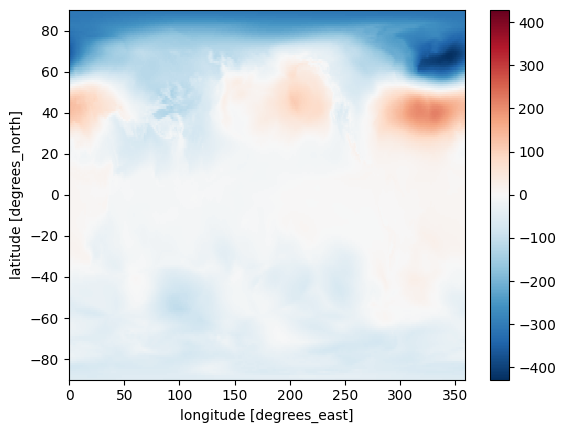

In [32]:
u.plot()

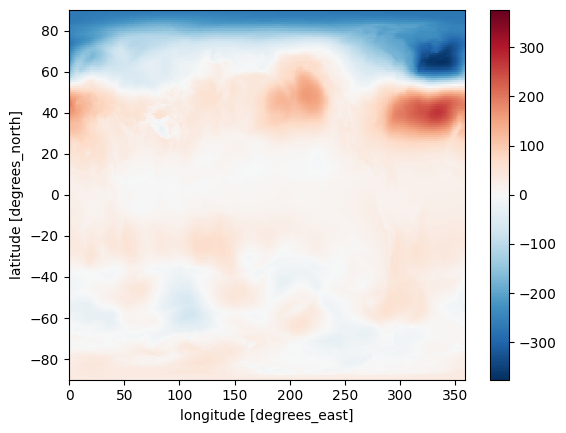

In [33]:
l.plot()

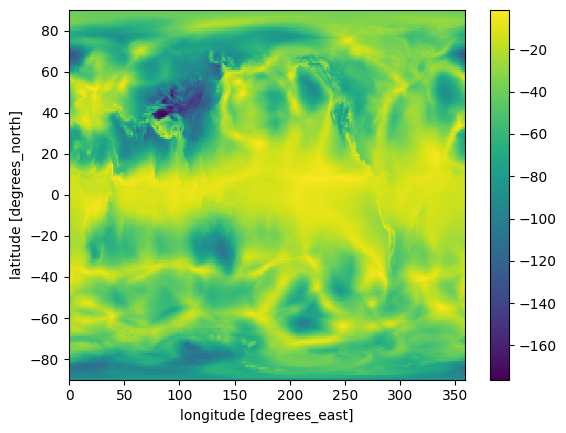

In [34]:
(u-l).plot()

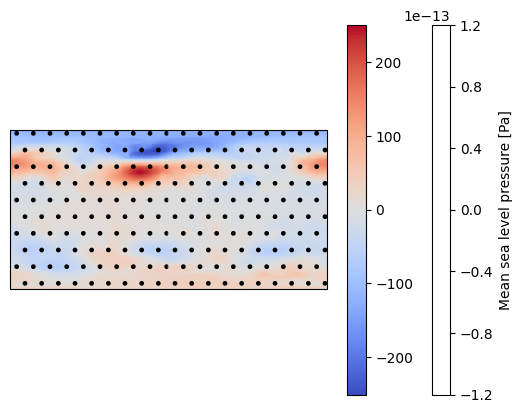

In [26]:
# Plot reg map and mask as stippling
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

reg_plot = map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)
mask.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches=['.', None], alpha=0)

fig.colorbar(reg_plot, ax=ax, orientation='vertical')

plt.show()

In [78]:
concordance_results /= num_bootstrap

In [75]:
# Define a new xarray with the concordance results
concordance_map = reg_test.copy(data=concordance_results)

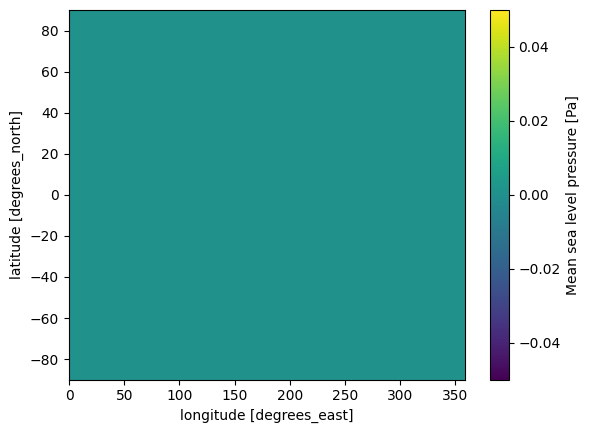

In [76]:
concordance_map.plot()